In [1]:
import tensorflow as tf

import os
import pathlib
import time
import datetime
import numpy as np

from matplotlib import pyplot as plt
from IPython import display

2022-12-09 18:09:02.079433: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-09 18:09:02.216434: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-12-09 18:09:03.489507: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/amazon/efa/lib64:/opt/amazon/openmpi/lib64:/usr/local/cuda/efa/lib:/usr/local/cuda/lib:/usr/local/cuda:/usr/local/cuda/lib64:/usr/local/cuda/extras/CUPTI/lib64:/usr/local/cuda/targets/x86_64-linux/lib:/usr/l

In [148]:
TRAIN_PATH = "../Dataset/Train/"
TEST_PATH = "../Dataset/Test/"
VAL_PATH = "../Dataset/Validation/"

L1_LAMBDA = 0.4
L2_LAMBDA = 0.0005

In [3]:
# load an image and corresponding elevation data from .npz file
def load(file):
  data = np.load(file)
  
  image = tf.convert_to_tensor(data["image"])
  elevation = tf.convert_to_tensor(data["elevation"])

  image = tf.cast(image, tf.float32)
  elevation = tf.cast(elevation, tf.float32)

  return image, elevation

In [4]:
# Size of the dta load buffer
BUFFER_SIZE = 500

# The batch size of 1 produced better results for the U-Net in the original pix2pix experiment
BATCH_SIZE = 1

# Each image is 256x256 in size
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [5]:
# Normalizing the RGB images to [-1, 1]
def normalize(image):
  image = (image / 127.5) - 1

  return image

In [6]:
# Perform a random flip in horizontal or vertical direction
def random_flip(image, elevation):
  u = tf.random.uniform(())
  if u < 1/3:
    image = tf.image.flip_left_right(image)
    elevation = tf.image.flip_left_right(elevation)

  elif u < 2/3:
    image = tf.image.flip_up_down(image)
    elevation = tf.image.flip_up_down(elevation)

  return image, elevation

In [7]:
# Chain the preprocessing functions together
def load_image_train(image_file):
  image, elevation = load(image_file)
  image = normalize(image)
  image, elevation = random_flip(image, elevation)

  return image, elevation

In [8]:
# Load test images, test images are not augmented
def load_image_test(image_file):
  image, elevation = load(image_file)
  image = normalize(image)

  return image, elevation

In [149]:
# Define the train dataset 
train_dataset = tf.data.Dataset.list_files(str(TRAIN_PATH + "*.npz"))
train_dataset = train_dataset.map(lambda x: tf.numpy_function(load_image_train, [x], (tf.float32, tf.float32)),
                                  num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

In [150]:
# Define the test dataset
test_dataset = tf.data.Dataset.list_files(str(TEST_PATH + '*.npz'))
test_dataset = test_dataset.map(lambda x: tf.numpy_function(load_image_test, [x], (tf.float32, tf.float32)))
test_dataset = test_dataset.batch(BATCH_SIZE)

In [12]:
# Downsample layer
def downsample(filters, size, apply_batchnorm=True, regularization=0):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  if regularization == 0:
    result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  else:
    result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False,
                             kernel_regularizer=tf.keras.regularizers.l2(regularization)))
  

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

In [13]:
# Upsample layer
def upsample(filters, size, apply_dropout=False, regularization=0):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  if regularization == 0:
    result.add(
      tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  else:
    result.add(
      tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False, kernel_regularizer=tf.keras.regularizers.l2(regularization)))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [14]:
# Define the U-Net generator
def Generator():
  inputs = tf.keras.layers.Input(shape=[256, 256, 3])

  down_stack = [
    downsample(64, 4, apply_batchnorm=False, regularization=L2_LAMBDA),  # (batch_size, 128, 128, 64)
    downsample(128, 4, regularization=L2_LAMBDA),  # (batch_size, 64, 64, 128)
    downsample(256, 4, regularization=L2_LAMBDA),  # (batch_size, 32, 32, 256)
    downsample(512, 4, regularization=L2_LAMBDA),  # (batch_size, 16, 16, 512)
    downsample(512, 4, regularization=L2_LAMBDA),  # (batch_size, 8, 8, 512)
    downsample(512, 4, regularization=L2_LAMBDA),  # (batch_size, 4, 4, 512)
    downsample(512, 4, regularization=L2_LAMBDA),  # (batch_size, 2, 2, 512)
    downsample(512, 4, regularization=L2_LAMBDA),  # (batch_size, 1, 1, 512)
  ]

  up_stack = [
    upsample(512, 4, apply_dropout=True, regularization=L2_LAMBDA),  # (batch_size, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True, regularization=L2_LAMBDA),  # (batch_size, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True, regularization=L2_LAMBDA),  # (batch_size, 8, 8, 1024)
    upsample(512, 4, regularization=L2_LAMBDA),  # (batch_size, 16, 16, 1024)
    upsample(256, 4, regularization=L2_LAMBDA),  # (batch_size, 32, 32, 512)
    upsample(128, 4, regularization=L2_LAMBDA),  # (batch_size, 64, 64, 256)
    upsample(64, 4, regularization=L2_LAMBDA),  # (batch_size, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(1, 4,
    strides=2, padding='same', kernel_initializer=initializer,
    activation='relu',kernel_regularizer=tf.keras.regularizers.l2(L2_LAMBDA))  # (batch_size, 256, 256, 3)

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1]) 

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [15]:
generator = Generator()

In [17]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [18]:
def generator_loss(disc_generated_output, gen_output, target):

  # Loss due to Discriminator
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # Mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  # Total loss
  total_gen_loss = gan_loss + (L1_LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss

In [19]:
# Define PatchGAN discriminator
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[None, None, 3], name='input_image')
  tar = tf.keras.layers.Input(shape=[None, None, 1], name='target_image')

  x = tf.keras.layers.concatenate([inp, tar], axis=-1)  # (batch_size, 256, 256, channels*2)

  down1 = downsample(64, 4, False)(x)  # (batch_size, 128, 128, 64)
  down2 = downsample(128, 4)(down1)  # (batch_size, 64, 64, 128)
  down3 = downsample(256, 4)(down2)  # (batch_size, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (batch_size, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1)  # (batch_size, 31, 31, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (batch_size, 33, 33, 512)

  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2)  # (batch_size, 30, 30, 1)

  return tf.keras.Model(inputs=[inp, tar], outputs=last)

In [20]:
discriminator = Discriminator()

In [21]:
def discriminator_loss(disc_real_output, disc_generated_output):

  # Loss on actual elevation data
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  # Loss on generated elevation data
  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)
  
  # Total discriminator loss
  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

In [22]:
# Optimizers
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [40]:
# Checkpoint to save model
checkpoint_dir = './training_checkpoints/'+str(L1_LAMBDA)+"/"+str(L2_LAMBDA)+"/"
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [176]:
# Function to plot results
def generate_images(model, test_input, tar, max_val = None):
  prediction = model(test_input, training=True)
  plt.figure(figsize=(15, 15))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])

    # Fix colorbar to max_val
    if max_val == None:
      plt.imshow(display_list[i] * 0.5 + 0.5)
    else:
      plt.imshow(display_list[i] * 0.5 + 0.5, vmax=max_val)
    plt.axis('off')

  plt.show()

In [226]:
# Define log directory and summary writer
log_dir="logs/lambda"+str(L1_LAMBDA)+"/"+str(L2_LAMBDA)+"/"

summary_writer = tf.summary.create_file_writer(
  log_dir + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [27]:
# Train step of the cGAN
@tf.function
def train_step(input_image, target, step):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)

    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)

    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

  with summary_writer.as_default():
    tf.summary.scalar('gen_total_loss', gen_total_loss, step=step//2000)
    tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=step//2000)
    tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=step//2000)
    tf.summary.scalar('disc_loss', disc_loss, step=step//2000)

In [28]:
# Define the fit function of the cGAN
def fit(train_ds, test_ds, steps):
  example_input, example_target = next(iter(test_ds.take(1)))
  start = time.time()

  for step, (input_image, target) in train_ds.repeat().take(steps).enumerate():
    if (step) % 1000 == 0:
      display.clear_output(wait=True)

      if step != 0:
        print(f'Time taken for 1000 steps: {time.time()-start:.2f} sec\n')

      start = time.time()

      print(f"Step: {step//1000}k")

    train_step(input_image, target, step)

    # Log progress on commandline
    if (step+1) % 100 == 0:
      print('.', end='', flush=True)


    # Save (checkpoint) the model every 2 epochs steps
    if (step + 1) % 46000 == 0:
      checkpoint.save(file_prefix=checkpoint_prefix)

In [30]:
# fit the model for steps
fit(train_dataset, test_dataset, steps=2300000)

In [ ]:
# get a tensorboard from logfiles

%load_ext tensorboard
%tensorboard --logdir {log_dir}

In [41]:
# Restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

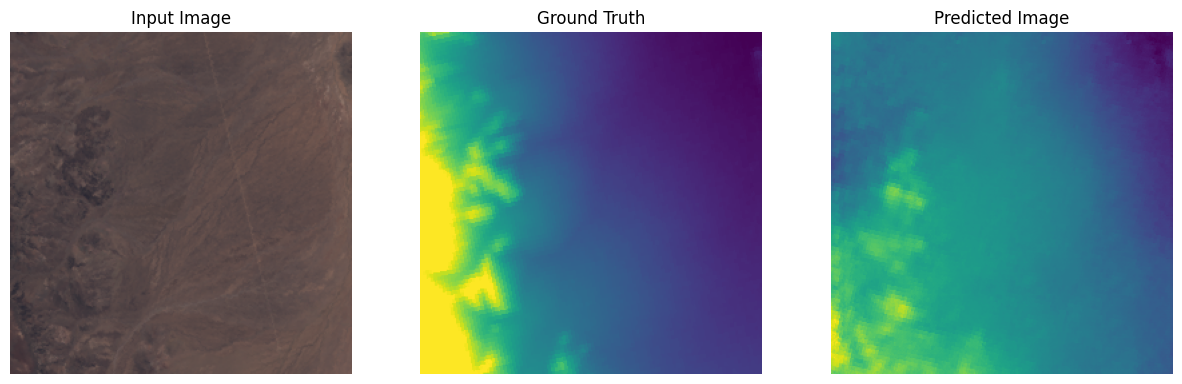

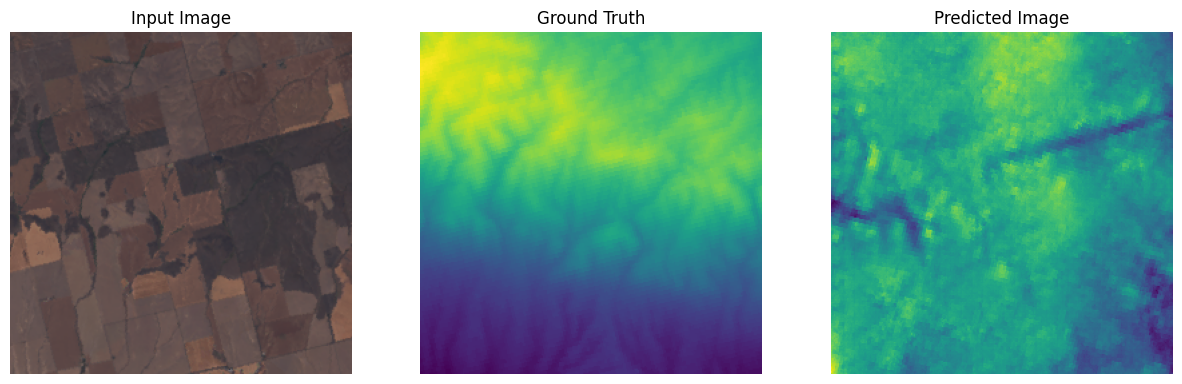

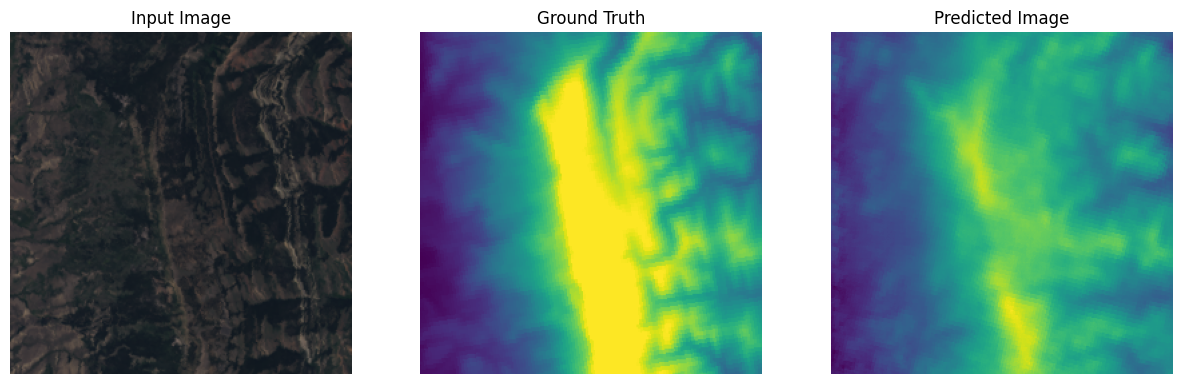

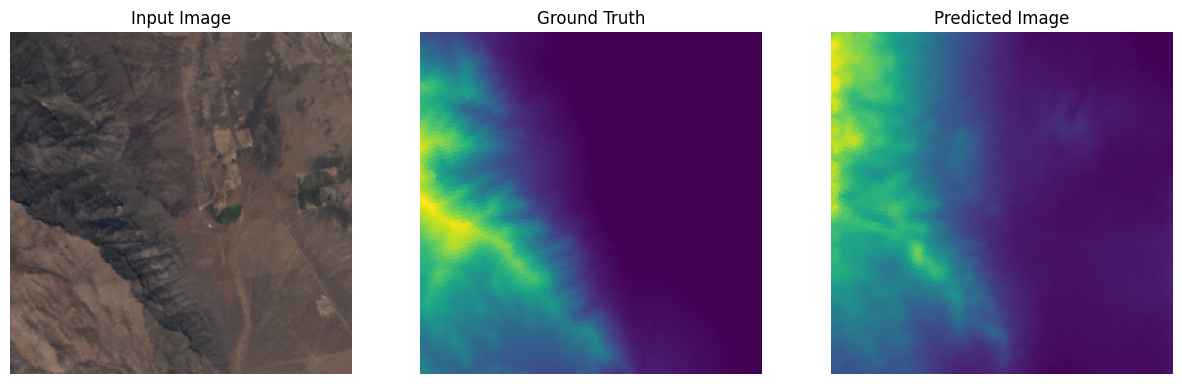

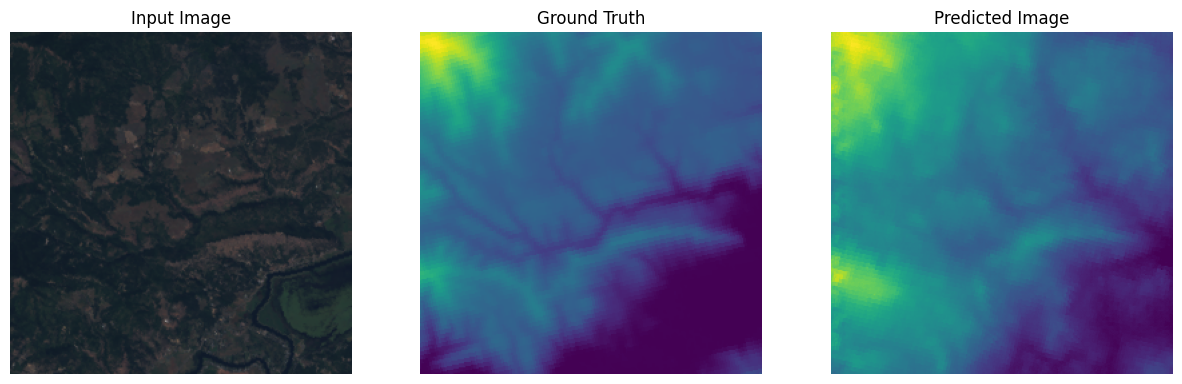

In [244]:
# Run the trained model on a few examples from the test set

for inp, tar in test_dataset.take(5):
  generate_images(generator, inp, tar)
  

In [159]:
# load custom images
sample_image = tf.keras.preprocessing.image.load_img("../test_image.jpg", target_size=(256,256), keep_aspect_ratio=True)
sample_image = tf.keras.preprocessing.image.img_to_array(sample_image)
sample_image = (sample_image / 127.5) - 1
sample_image = tf.convert_to_tensor([sample_image])

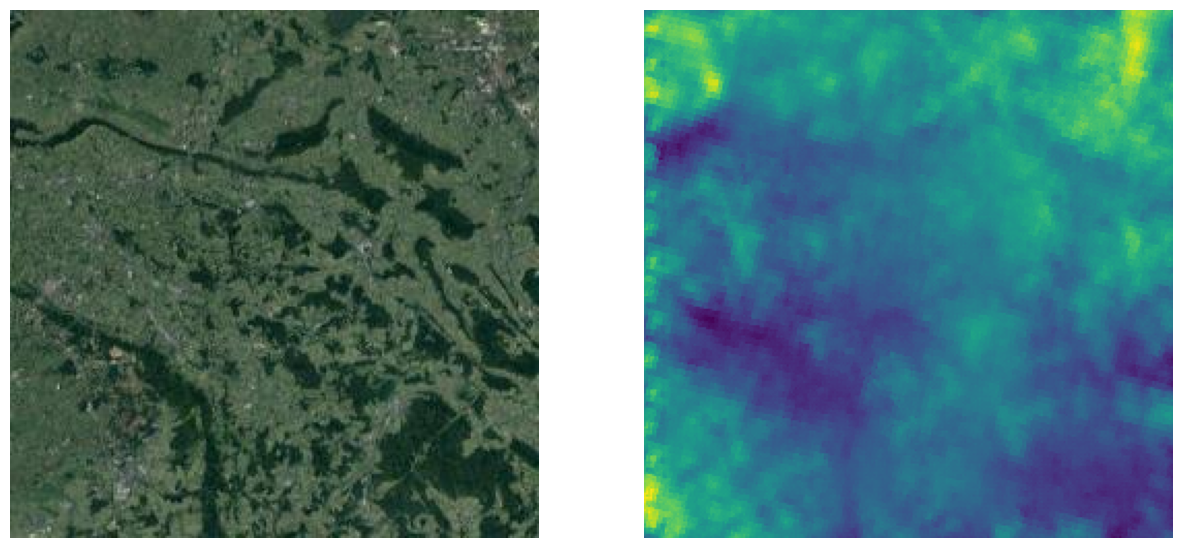

In [245]:
display_list = [sample_image[0], generator(sample_image, training=True)[0]]
plt.figure(figsize=(15, 15))
for i in range(len(display_list)):
    plt.subplot(1,len(display_list),i+1)
    plt.imshow(display_list[i]*0.5 + 0.5)
    plt.axis('off')

plt.show()